# _(Wang & Buzsáki, 1996)_ Gamma Oscillation

Here we show the implementation of gamma oscillation proposed by Xiao-Jing Wang and György Buzsáki (1996). They demonstrated that the GABA$_A$ synaptic transmission provides a suitable mechanism for synchronized gamma oscillations in a network of fast-spiking interneurons. 

Let's first import brainpy and set profiles.

In [1]:
import brainpy as bp

bp.integrators.set_default_odeint('rk4')

The network is constructed with Hodgkin–Huxley (HH) type neurons and GABA$_A$ synapses. 

The GABA$_A$ synapse is coded as:

In [2]:
class GABAa(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, delay=0., g_max=0.1, E=-75.,
                 alpha=12., beta=0.1, T=1.0, T_duration=1.0, **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = self.conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.t_last_pre_spike = bp.ops.ones(self.size) * -1e7
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

        super(GABAa, self).__init__(pre=pre, post=post, **kwargs)

    @staticmethod
    @bp.odeint
    def int_s(s, t, TT, alpha, beta):
        return alpha * TT * (1 - s) - beta * s

    def update(self, _t):
        for i in range(self.pre.size[0]):
            if self.pre.spike[i] > 0:
                self.t_last_pre_spike[i] = _t
        TT = ((_t - self.t_last_pre_spike) < self.T_duration) * self.T
        self.s = self.int_s(self.s, _t, TT, self.alpha, self.beta)
        self.g.push(self.g_max * self.s)
        g = self.g.pull()
        self.post.input -= bp.ops.sum(g, axis=0) * (self.post.V - self.E)

The dynamics of the HH type neurons is given by:

$$ C \frac {dV} {dt} = -(I_{Na} + I_{K} + I_L) + I(t) $$

where $I(t)$ is the injected current, the leak current $ I_L = g_L (V - E_L) $, and the transient sodium current 

$$ I_{Na} = g_{Na} m_{\infty}^3 h (V - E_{Na}) $$

where the activation variable $m$ is assumed fast and substituted by its steady-state function 
$m_{\infty} = \alpha_m / (\alpha_m + \beta_m)$.
And the inactivation variable $h$ obeys a first=order kinetics:
$$ \frac {dh} {dt} = \phi (\alpha_h (1-h) - \beta_h h)$$

$$ I_K = g_K n^4 (V - E_K) $$

where the activation variable $n$ also obeys a first=order kinetics:
$$ \frac {dn} {dt} = \phi (\alpha_n (1-n) - \beta_n n)$$

In [3]:
class HH(bp.NeuGroup):
    target_backend = 'general'

    def __init__(self, size, ENa=55., EK=-90., EL=-65,
                 C=1.0, gNa=35., gK=9., gL=0.1, V_th=20.,
                 phi=5.0, **kwargs):
        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th
        self.phi = phi

        # variables
        self.V = bp.ops.ones(size) * -65.
        self.h = bp.ops.ones(size) * 0.6
        self.n = bp.ops.ones(size) * 0.32
        self.spike = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)

        super(HH, self).__init__(size=size, **kwargs)

    @staticmethod
    @bp.odeint
    def integral(V, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C, phi):
        alpha = 0.07 * bp.ops.exp(-(V + 58) / 20)
        beta = 1 / (bp.ops.exp(-0.1 * (V + 28)) + 1)
        dhdt = alpha * (1 - h) - beta * h

        alpha = -0.01 * (V + 34) / (bp.ops.exp(-0.1 * (V + 34)) - 1)
        beta = 0.125 * bp.ops.exp(-(V + 44) / 80)
        dndt = alpha * (1 - n) - beta * n

        m_alpha = -0.1 * (V + 35) / (bp.ops.exp(-0.1 * (V + 35)) - 1)
        m_beta = 4 * bp.ops.exp(-(V + 60) / 18)
        m = m_alpha / (m_alpha + m_beta)
        INa = gNa * m ** 3 * h * (V - ENa)
        IK = gK * n ** 4 * (V - EK)
        IL = gL * (V - EL)
        dVdt = (- INa - IK - IL + Iext) / C

        return dVdt, phi * dhdt, phi * dndt

    def update(self, _t):
        V, h, n = self.integral(self.V, self.h, self.n, _t,
                                self.input, self.gNa, self.ENa, self.gK,
                                self.EK, self.gL, self.EL, self.C, self.phi)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.h = h
        self.n = n
        self.input[:] = 0


Let's run a simulation of a network with 100 neurons with constant inputs (1 $\mu$A/cm$^2$).

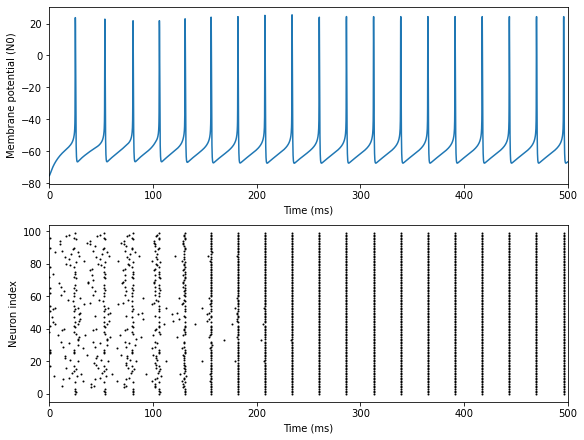

In [4]:
num = 100
neu = HH(num, monitors=['spike', 'V'])
neu.V = -70. + bp.ops.normal(size=num) * 20

syn = GABAa(pre=neu, post=neu, conn=bp.connect.All2All(include_self=False))
syn.g_max = 0.1 / num

net = bp.Network(neu, syn)
net.run(duration=500., inputs=[neu, 'input', 1.], report=False)

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
xlim = (net.t_start - 0.1, net.t_end + 0.1)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(net.ts, neu.mon.V, xlim=xlim, ylabel='Membrane potential (N0)')

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(net.ts, neu.mon.spike, xlim=xlim, show=True)


We can see the result of this simulation that cells starting at random and asynchronous initial conditions quickly become synchronized and their spiking times are perfectly in-phase within 5-6 oscillatory cycles.

### Reference

[1] Wang, Xiao-Jing, and György Buzsáki. “Gamma oscillation by
synaptic inhibition in a hippocampal interneuronal network
model.” Journal of neuroscience 16.20 (1996): 6402-6413.